# Analyzing Car Expenses Based on Receipts 

This notebook goes through some interesting stats about how much it has cost us to own a car. Since purchasing the car, I have been saving receipts from all car-related expenses. There are periods where other people have borrowed the car and fueled it up without saving the receipt, so consider this a lower bound on the expenses.

## Table of Contents:
* [Overview: Where Did the Money Go?](#first-bullet)
* [Parking: What's Space Worth Anyways?](#second-bullet)
    * [Seasonality in Parking](#second-bullet-s2)
    * [Who Do We Pay for Parking?](#second-bullet-s3)
* [Gas Prices: Fuelling my Pain!](#third-bullet)
    * [Gas Prices over Time](#third-bullet-s2)
    * [What's the Final Price Tag for Fuel Consumption?](#third-bullet-s3)
    * [Buy Low, Wait High?](#third-bullet-s4)
    * [To the Cheapest Gas Station Please!](#third-bullet-s5)

In [1]:
## Toggle function from:
## https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
from IPython.display import HTML
import random

def hide_toggle(for_next=False, toggle_text = 'Toggle show/hide'):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    #toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

# Packages
from pathlib import Path
import os
import pandas as pd
import numpy as np
from datetime import datetime

import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pio.renderers.default = "svg"   ## for showing plotly graphs when uploading notebook to Github

## Setting CWD
cwd = os.getcwd()
root = Path(cwd).parents[0]
datadir = str(Path(root)) + str('/data')
outputdir = str(Path(root)) + str('/output')

hide_toggle(toggle_text = 'Expand code for settings')

In [2]:
infile = datadir + "/raw_data.xlsx"

df = pd.read_excel(infile, sheet_name='Blad1')

df_bränsle = pd.read_excel(infile, sheet_name='bränsle')

df_bränsle_snittpriser = pd.read_excel(infile, sheet_name='bränsle_snittpriser')

df = df.append(df_bränsle[['Datum','Utgift']], ignore_index=True)      ## Appending relevant fuel data
df['Kategori'].replace(np.nan, 'Bränsle', inplace=True)              ## Fixing Category variable

hide_toggle(toggle_text = 'Expand code for loading data')

# Where Did the Money Go?  <a class="anchor" id="first-bullet"></a>

Let's break up the total costs of the car by category.

In [3]:
print(f"The data contains information on the following categories: {list(df.Kategori.unique())}")
hide_toggle(toggle_text = 'Expand code')

The data contains information on the following categories: ['Övrigt', 'Tvätt', 'Parkering', 'Skatt', 'Service', 'Försäkring', 'Månadsavgifter', 'Besiktning', 'Bränsle']


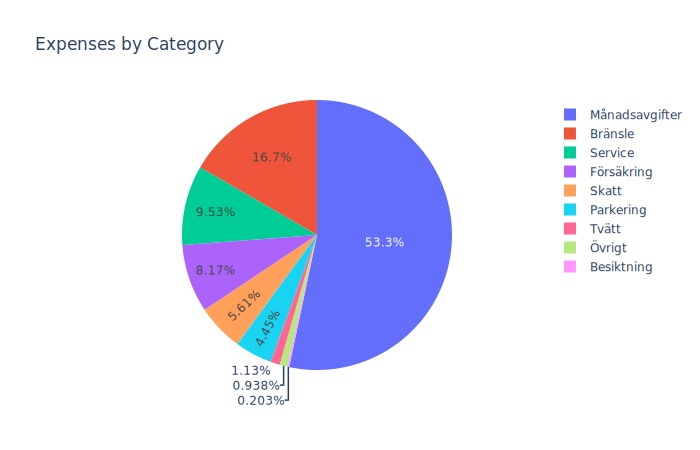

In [4]:
df_kategori = df.groupby('Kategori').sum().reset_index()

fig = px.pie(df_kategori, values='Utgift', names='Kategori', title='Expenses by Category')
fig.show()

hide_toggle(toggle_text = 'Expand code')

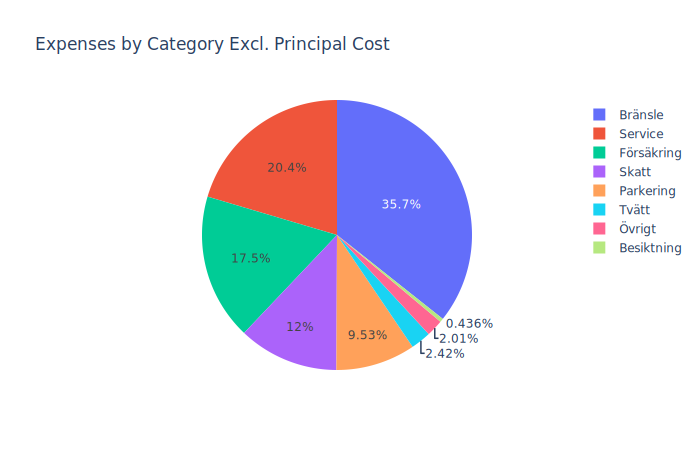

In [5]:
df_kategori = df[df['Kategori']!="Månadsavgifter"].groupby('Kategori').sum().reset_index()

fig = px.pie(df_kategori, values='Utgift', names='Kategori', title='Expenses by Category Excl. Principal Cost')
fig.show()
hide_toggle(toggle_text = 'Expand code')

In the figure above, we see that the greatest expenses was purchasing the car. This is followed by paying for service, fuel and insurance.

# Parking: What's Space Worth Anyways?  <a class="anchor" id="second-bullet"></a>

How much have we paid for parking, in total? Let's take a look!

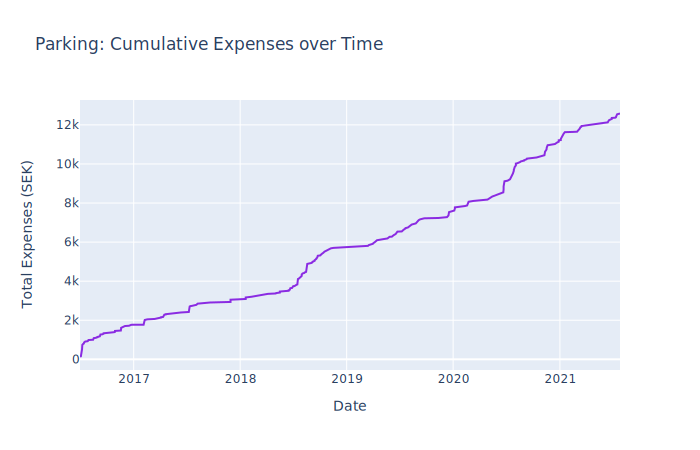

In [6]:
df_parkering = df[df['Kategori']=="Parkering"].reset_index()
df_parkering['Utgift_cumulative'] = df_parkering.loc[::-1, 'Utgift'].cumsum()[::-1]

fig = px.line(df_parkering,
              x='Datum',
              y='Utgift_cumulative',
              title = f'Parking: Cumulative Expenses over Time',
              labels={"Utgift_cumulative": "Total Expenses (SEK)","Datum": "Date"},
              color_discrete_sequence=["blueviolet"])

fig.show()
hide_toggle(toggle_text = 'Expand code')

In [7]:
print(f"Between the {df_parkering.Datum.min().strftime('%d %B %Y')} and {df_parkering.Datum.max().strftime('%d %B %Y')}, {df_parkering.Utgift.count()} parking occasions have cost us a total of {df_parkering.Utgift_cumulative.max():7.2f} SEK.")
hide_toggle(toggle_text = 'Expand code')

Between the 01 July 2016 and 26 July 2021, 329 parking occasions have cost us a total of 12582.89 SEK.


## Seasonality in Parking <a class="anchor" id="second-bullet-s2"></a>

What does the daily parking price tag look like?

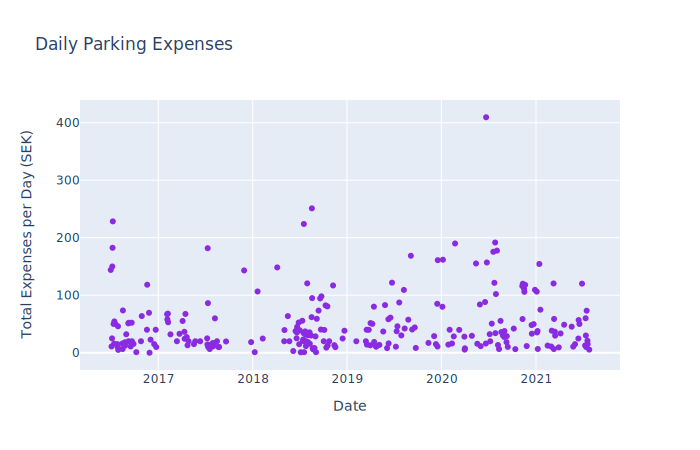

In [8]:
fig = px.scatter(df_parkering[['Datum','Utgift']].groupby('Datum').sum().reset_index(),
              x='Datum',
              y='Utgift',
              title = 'Daily Parking Expenses',
              labels={"Utgift": "Total Expenses per Day (SEK)","Datum": "Date"},
              color_discrete_sequence=["blueviolet"]
             )

fig.show()
hide_toggle(toggle_text = 'Expand code')

### How has my average spending on parking changed over time?

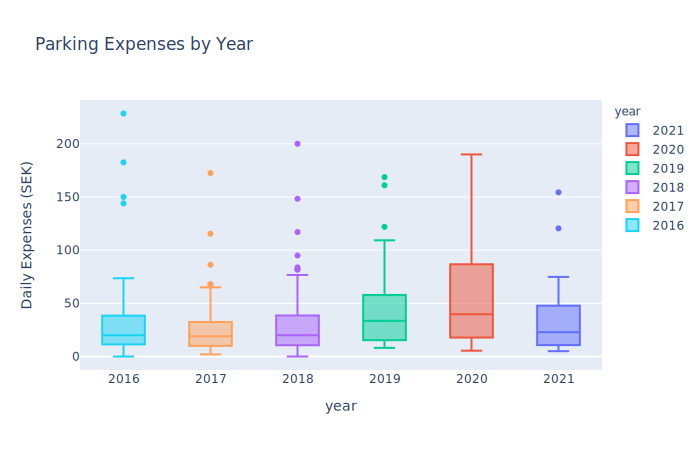

In [9]:
df_parkering['year'], df_parkering['month'] = df_parkering['Datum'].dt.year, df_parkering['Datum'].dt.month

fig = px.box(df_parkering,
             x='year',
             y='Utgift',
             color='year',
             title='Parking Expenses by Year')

fig.update_yaxes(title_text="Daily Expenses (SEK)")

fig.show()
hide_toggle(toggle_text = 'Expand code')

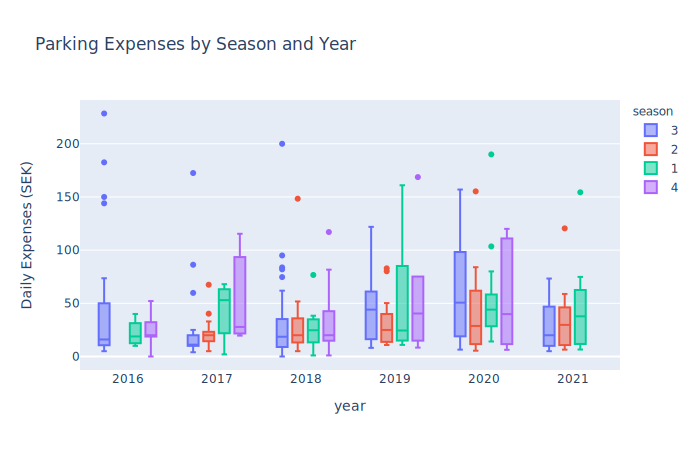

In [10]:
df_parkering['season'] = df_parkering.Datum.dt.month%12 // 3 + 1

fig = px.box(df_parkering,
             x='year',
             y='Utgift',
             color='season',
             title='Parking Expenses by Season and Year')

fig.update_yaxes(title_text="Daily Expenses (SEK)")

fig.show()
hide_toggle(toggle_text = 'Expand code')

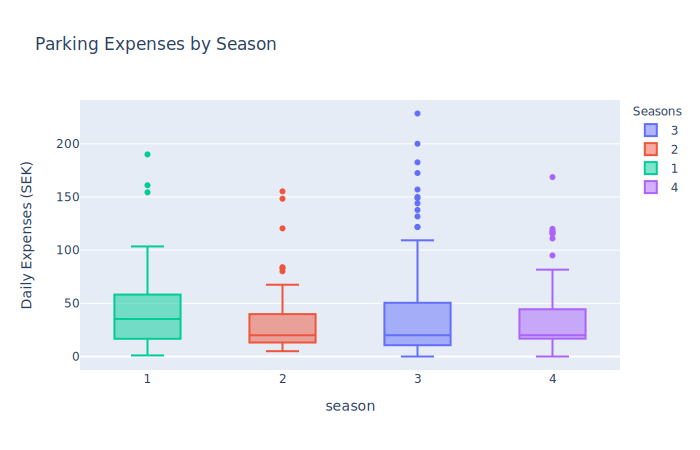

In [11]:
fig = px.box(df_parkering,
             x='season',
             y='Utgift',
             color='season',
             title='Parking Expenses by Season')

fig.update_yaxes(title_text="Daily Expenses (SEK)")
fig.update_layout(legend_title_text='Seasons')

fig.show()
hide_toggle(toggle_text = 'Expand code')

## Who Do We Pay for Parking? <a class="anchor" id="second-bullet-s3"></a>
Let's break down the parking data by parking firm.

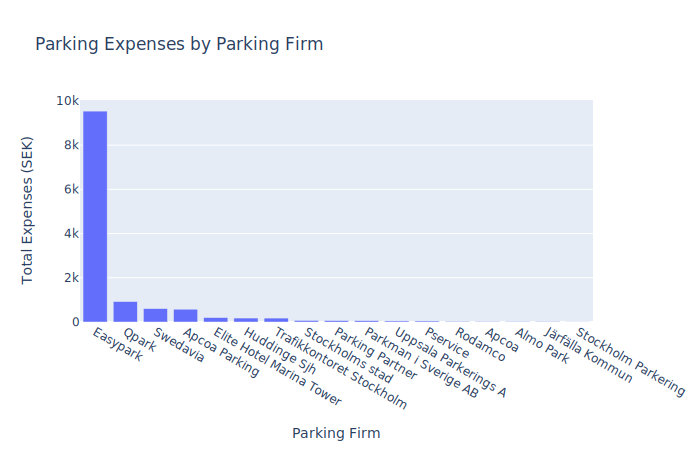

The winner is: Easypark!


In [12]:
fig = px.bar(df_parkering[['Typ','Utgift']].groupby('Typ').sum(),
             title='Parking Expenses by Parking Firm')

fig.update_yaxes(title_text="Total Expenses (SEK)")
fig.update_xaxes(title_text="Parking Firm", categoryorder="total descending")
fig.update_layout(showlegend=False)

fig.show()

print(f"The winner is: {df_parkering[['Typ', 'Utgift']].groupby('Typ').sum().reset_index().sort_values('Utgift', ascending=False).Typ.values[0]}!")


hide_toggle(toggle_text = 'Expand code')

# Gas Prices: Fuelling my Pain! <a class="anchor" id="third-bullet"></a>

In second place in terms of expenses, after paying for the actual car, was paying for fuel. Let's explore the fuel receipts!

## Gas Prices over Time <a class="anchor" id="third-bullet-s2"></a>

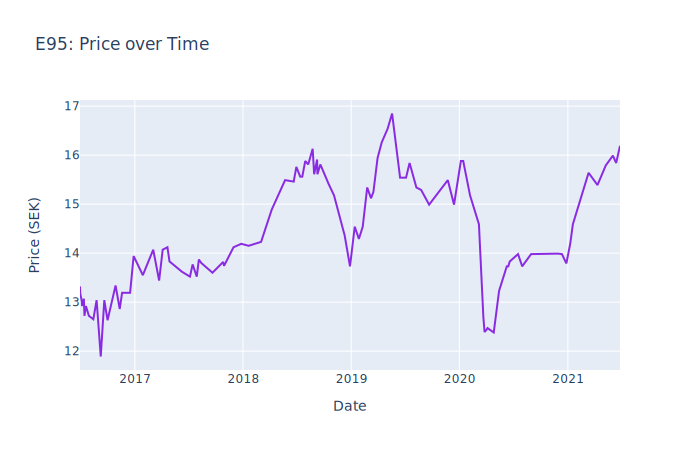

In [13]:
fig = px.line(df_bränsle,
              x='Datum',
              y='Pris',
              title = f'E95: Price over Time',
              labels={"Pris": "Price (SEK)","Datum": "Date"},
              color_discrete_sequence=["blueviolet"])

fig.show()
hide_toggle(toggle_text = 'Expand code')

In [14]:
print(f"The figure above shows that fuel prices have been as low as {df_bränsle.Pris.min()} SEK and reached a maximum of {df_bränsle.Pris.max()} SEK. \nThe latest price is{df_bränsle.Pris.head(1).mean(): .2f} SEK.")
hide_toggle(toggle_text = 'Expand code')

The figure above shows that fuel prices have been as low as 11.89 SEK and reached a maximum of 16.85 SEK. 
The latest price is 16.19 SEK.


How good am I at fueling from price-worthy gas stations? Let's compare the prices from my fuel receipts with average daily prices of fuel in Sweden!

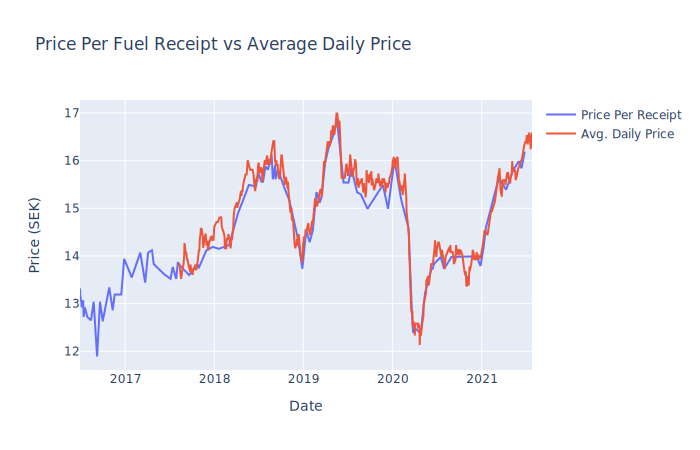

In [15]:
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x=df_bränsle['Datum'], y=df_bränsle['Pris'], name="Price Per Receipt")
)

fig.add_trace(
    go.Scatter(x=df_bränsle_snittpriser['Datum'], y=df_bränsle_snittpriser['E95'], name="Avg. Daily Price")
)

# Add figure title
fig.update_layout(
    title_text="Price Per Fuel Receipt vs Average Daily Price"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Price (SEK)")

fig.show()
hide_toggle(toggle_text = 'Expand code')

The price at which I fuel the car seems to be consistently equal to or less than the average price of fuel. Not too bad!

## What's the Final Price Tag for Fuel Consumption? <a class="anchor" id="third-bullet-s3"></a>

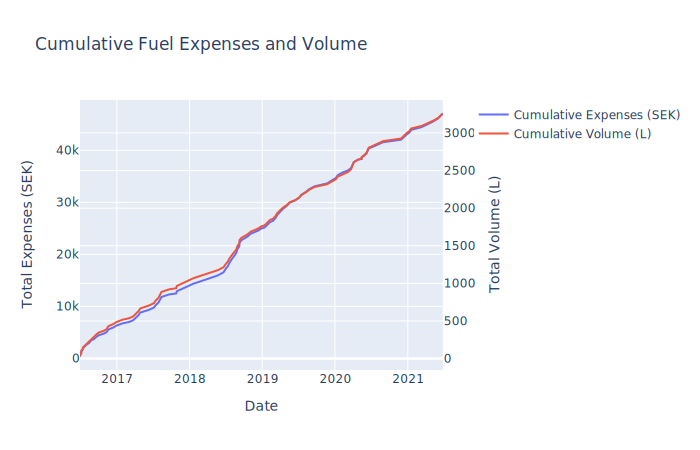

In [16]:
df_bränsle['Utgift_cumulative'] = df_bränsle.loc[::-1, 'Utgift'].cumsum()[::-1]
df_bränsle['L_cumulative'] = df_bränsle.loc[::-1, 'L'].cumsum()[::-1]

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_bränsle['Datum'], y=df_bränsle['Utgift_cumulative'], name="Cumulative Expenses (SEK)"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_bränsle['Datum'], y=df_bränsle['L_cumulative'], name="Cumulative Volume (L)"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Cumulative Fuel Expenses and Volume"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Total Expenses (SEK)", secondary_y=False)
fig.update_yaxes(title_text="Total Volume (L)", secondary_y=True)

fig.show()
hide_toggle(toggle_text = 'Expand code')

In [17]:
print(f"The final price tag is{df_bränsle.Utgift_cumulative.head(1).mean(): .2f} SEK, for a total of{df_bränsle.L_cumulative.head(1).mean(): .2f} litres of fuel. \nThat is equivalent to around{df_bränsle.L_cumulative.head(1).mean()/40: .2f} full tanks.")
hide_toggle(toggle_text = 'Expand code')

The final price tag is 47080.44 SEK, for a total of 3258.25 litres of fuel. 
That is equivalent to around 81.46 full tanks.


## Buy Low, Wait High? <a class="anchor" id="third-bullet-s4"></a>

Do I tend to buy more fuel when the prices are relatively low?

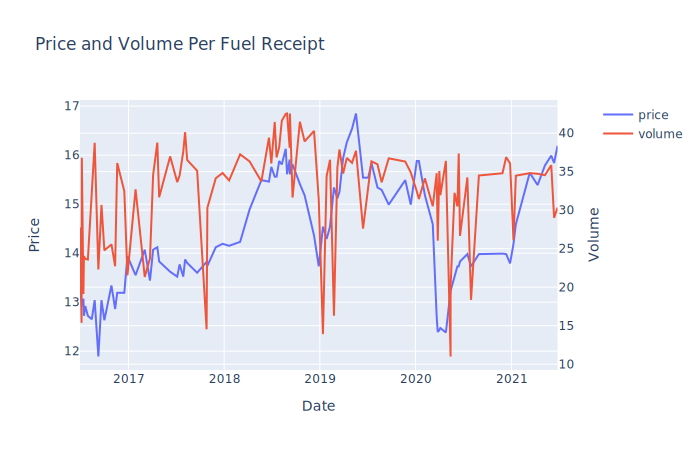

In [18]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_bränsle['Datum'], y=df_bränsle['Pris'], name="price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_bränsle['Datum'], y=df_bränsle['L'], name="volume"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Price and Volume Per Fuel Receipt"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Price", secondary_y=False)
fig.update_yaxes(title_text="Volume", secondary_y=True)

fig.show()
hide_toggle(toggle_text = 'Expand code')

A quick visual inspection of price and volume data shows that there may be such a negative co-movement until July 2018. Since then, which co-incides with me moving from Uppsala to Stockholm, there isn't a clear pattern. If anything, we fuel up more when prices are higher!

In [19]:
print(f"In summary, between the {df_bränsle.Datum.min().strftime('%d of %B %Y')} and {df_bränsle.Datum.max().strftime('%d of %B %Y')}:\n")
print(f"- Recorded entries: {df_bränsle.Datum.count()}\n")
print(f"- Min. Price: {df_bränsle.Pris.min()} SEK")
print(f"- Avg. Price: {df_bränsle.Pris.mean():.2f} SEK")
print(f"- Max. Price: {df_bränsle.Pris.max()} SEK\n")
print(f"- Min. Fuel Litres: {df_bränsle.L.min()} L")
print(f"- Avg. Fuel Litres: {df_bränsle.L.mean():.2f} L")
print(f"- Max. Fuel Litres: {df_bränsle.L.max()} L\n")

print(f"- Total Expenses: {df_bränsle.Utgift_cumulative.head(1).mean():.2f} SEK")
print(f"- Total Litres: {df_bränsle.L_cumulative.head(1).mean():.2f} L\n")

print(f"- Nr Gas Station Chains: {df_bränsle.Företag.nunique()}")
hide_toggle(toggle_text = 'Expand code')

In summary, between the 30 of June 2016 and 26 of June 2021:

- Recorded entries: 101

- Min. Price: 11.89 SEK
- Avg. Price: 14.34 SEK
- Max. Price: 16.85 SEK

- Min. Fuel Litres: 11.0 L
- Avg. Fuel Litres: 32.26 L
- Max. Fuel Litres: 42.55 L

- Total Expenses: 47080.44 SEK
- Total Litres: 3258.25 L

- Nr Gas Station Chains: 5


## To The Cheapest Gas Station, Please! <a class="anchor" id="third-bullet-s5"></a>

Which gas station chains do I usually fuel up at, and are they the cheapest?

In [20]:
df_bränsle_grouped = pd.pivot_table(df_bränsle, values='Pris', index=['Datum'],columns='Företag', aggfunc=np.sum).reset_index()
print(f"From the table below, we see that I usually fuel up at Ingo (a total of {df_bränsle_grouped['Ingo'].count()} times).")
print(f"On average, St1 has lower gas prices than the rest ({df_bränsle_grouped['St1'].describe()['mean']:.2f} SEK).")
print(f"However, I used to fuel at St1 when I lived in Uppsala, where fuel is generally cheaper.")

display(df_bränsle_grouped.describe())
hide_toggle(toggle_text = 'Expand code')

From the table below, we see that I usually fuel up at Ingo (a total of 67 times).
On average, St1 has lower gas prices than the rest (13.85 SEK).
However, I used to fuel at St1 when I lived in Uppsala, where fuel is generally cheaper.


Företag,Circle K,Ingo,OKQ8,Shell,St1
count,11.000000,67.000000,2.000000,1.00,19.000000
mean,14.346364,14.511194,14.555000,26.46,13.848421
std,1.145454,1.174373,1.110158,NaN,1.157076
min,13.070000,12.380000,13.770000,26.46,11.890000
25%,13.560000,13.730000,14.162500,26.46,13.115000
50%,13.940000,14.540000,14.555000,26.46,13.600000
75%,15.235000,15.550000,14.947500,26.46,14.190000
max,16.130000,16.850000,15.340000,26.46,16.260000


Let's compare fuel prices from the gas station chains, based on my saved receipts.

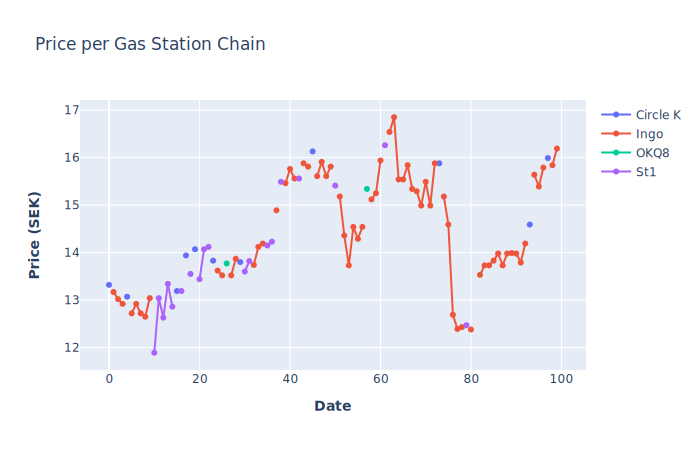

In [21]:
fig = go.Figure()
for col in df_bränsle_grouped[['Circle K','Ingo','OKQ8','St1']].columns:
    fig.add_trace(go.Scatter(x=df_bränsle_grouped.index, y=df_bränsle_grouped[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear')
                             )
                 )
    
fig.update_layout(
    title_text="Price per Gas Station Chain"
)

fig.update_xaxes(title_text="<b>Date</b>")
fig.update_yaxes(title_text="<b>Price (SEK)</b>")

fig.show()
hide_toggle(toggle_text = 'Expand code')

There are many problems with trying to compare fuel prices from the gas chains based on my receipts. First, since I rarely fuel up from multiple gas Stations on the same day, we cannot compare the fuel prices. Second of all, it is not random where I fuel up the car. My favorite chain is Ingo, and I often drive past a couple of other gas stations (which sell fuel at a higher price) on my way there.

## End